## Quick look at the submition for the verification binaries 

In [33]:
### importing modules

import numpy as np
import os, sys, re
import time
import glob

from LISAhdf5 import LISAhdf5,ParsUnits
import tdi

import yaml, pandas, csv

import FastGB

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl


import corner

#### useful functions and parameters 


In [34]:
### Some settings
plotpal = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]

### Get parameters of the source specified by index
def GetParams(p, ind):
    bet = p.get('EclipticLatitude')[ind]
    lam = p.get('EclipticLongitude')[ind]
    Amp = p.get("Amplitude")[ind]
    f0 = p.get("Frequency")[ind]
    fdot = p.get("FrequencyDerivative")[ind]
    iota = p.get("Inclination")[ind]
    psi = p.get("Polarization")[ind]
    phi0 = p.get("InitialPhase")[ind]

    return (bet, lam, Amp, f0, fdot, iota, psi, phi0)


### Window function used in fft
def Window(tm, offs=1000.0):

    xl = offs
    ind_r = np.argwhere(tm[-1]-tm <= offs)[0][0]
    xr = tm[ind_r]
    # print (xr)
    kap = 0.005
    winl = 0.5*(1.0 + np.tanh(kap*(tm-xl)))
    winr = 0.5*(1.0 - np.tanh(kap*(tm-xr)))
    # plt.plot(tm, winl)
    # plt.plot(tm, winr)
    # plt.grid(True)
    # plt.show()
    return (winl*winr)


from scipy import stats
def jensen_shannon_divergence(
    samples, kde=stats.gaussian_kde, decimal=5, base=np.e, **kwargs
):
    """Calculate the JS divergence between two sets of samples

    Parameters
    ----------
    samples: list
        2d list containing the samples drawn from two pdfs
    kde: func
        function to use when calculating the kde of the samples
    decimal: int, float
        number of decimal places to round the JS divergence to
    base: float, optional
        optional base to use for the scipy.stats.entropy function. Default
        np.e
    kwargs: dict
        all kwargs are passed to the kde function
    """
    try:
        kernel = [kde(i, **kwargs) for i in samples]
    except np.linalg.LinAlgError:
        return float("nan")
    x = np.linspace(
        np.min([np.min(i) for i in samples]),
        np.max([np.max(i) for i in samples]),
        100
    )
    a, b = [k(x) for k in kernel]
    a = np.asarray(a)
    b = np.asarray(b)
    a /= a.sum()
    b /= b.sum()
    m = 1. / 2 * (a + b)
    kl_forward = stats.entropy(a, qk=m, base=base)
    kl_backward = stats.entropy(b, qk=m, base=base)
    return np.round(kl_forward / 2. + kl_backward / 2., decimal)


### Reading the data for VGBs and performing FFT

In [35]:



DATAPATH = "/home/stefan/LDC/Radler/data"
sangria_fn = DATAPATH + "/LDC1-3_VGB_v2.hdf5"
FD5 = LISAhdf5(sangria_fn)
Nsrc = FD5.getSourcesNum()
GWs = FD5.getSourcesName()
print ("Found %d GW sources: " % Nsrc, GWs)
### TODO make sure GalBin is there
if (GWs[0] != 'GalBinaries'):
    raise NotImplementedError
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))

p.display()
Nsrc = len(p.get('Frequency'))

df = 1.0/Tobs
XDt = td[:, 1]
tm = td[:, 0]
win = Window(tm)


XDf = np.fft.fft(win*td[:, 1])
YDf = np.fft.fft(win*td[:, 2])
ZDf = np.fft.fft(win*td[:, 3])
freqD = np.fft.fftfreq(len(tm), del_t)
 
Nfd = len(freqD)
Nfd = int(Nfd/2)
freqD = freqD[:Nfd]  ### we use only positive frequencies
Adf = (ZDf[:Nfd] - XDf[:Nfd])/np.sqrt(2.0)
Edf = (ZDf[:Nfd] - 2.0*YDf[:Nfd] + XDf[:Nfd])/np.sqrt(6.0)
Adf = Adf * del_t
Edf = Edf * del_t  ### Due to fft conventions


fastGB = FastGB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic")

Found 1 GW sources:  ['GalBinaries']
s
	Amplitude [1.07345e-22 1.36368e-22 1.76276e-22 7.34608e-23 1.50933e-22 5.35906e-23
 3.29570e-23 7.39547e-23 6.37823e-23 1.66997e-22] [strain]
	Cadence 15.0 [Seconds]
	EclipticLatitude [ 0.312414  -0.529009   0.0865683  0.490263   0.653451  -0.354825
  0.816989   0.490263  -0.082205   0.101404 ] [Radian]
	EclipticLongitude [-2.75291 -2.51031 -2.18009  2.28603  2.97387  0.4297  -1.13534  2.28603
  2.10225  1.76872] [Radian]
	Frequency [0.00135962 0.00125313 0.00181324 0.00166667 0.00194414 0.00322061
 0.0035125  0.0016835  0.00622028 0.00261301] [Hz]
	FrequencyDerivative [8.94581279e-19 9.15958730e-19 2.04973995e-18 2.18905890e-18
 6.48972578e-18 1.74586691e-17 2.78570006e-17 2.27120824e-18
 7.48528554e-16 2.90562842e-17] [Hz^2]
	Inclination [0.523599   0.244346   0.523599   1.22173    0.750492   1.6169347
 1.5063286  1.67948105 0.645772   1.51669   ] [Radian]
	InitialPhase [3.0581565  2.64414439 2.97459105 3.2219877  3.00689165 2.84090075
 3.18551

/home/stefan/.local/lib/python3.7/site-packages/LISAhdf5.py:508: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  params.addPar(ky,p.value,Str(p.attrs['Units']))
/home/stefan/.local/lib/python3.7/site-packages/LISAhdf5.py:742: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = np.copy(self.h5file['H5LISA/PreProcess/TDIdata'].value)


In [36]:
### Dictionary of events: need to map different submission index to VGBs in the catalogue

VGBs = {'GW135962': {'BC':3, 'MM':1, 'BH':6, 'S':0},  
        'GW125313': {'BC':4, 'MM':7, 'BH':4, 'S':1},
        'GW181324': {'BC':8, 'MM':2, 'BH':5, 'S':2},
        'GW166667': {'BC':1, 'MM':9, 'BH':3, 'S':3},
        'GW194414': {'BC':5, 'MM':0, 'BH':9, 'S':4},
        'GW322061': {'BC':6, 'MM':5, 'BH':1, 'S':5},
        'GW351250': {'BC':0, 'MM':6, 'BH':2, 'S':6}, 
        'GW168350': {'BC':2, 'MM':3, 'BH':8, 'S':7},
        'GW622028': {'BC':7, 'MM':8, 'BH':7, 'S':8},
        'GW261301': {'BC':9, 'MM':4, 'BH':0, 'S':9}}

### Read Barcelona data (from ice-csic-ieec)

In [37]:
Barc_data = []
Barc_data_pnd = []

fls = glob.glob('/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/*.csv')
print (fls)

# with open(fls[0]) as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for raw in csv_reader:
#         print (raw)
#         break

for fl in fls:
#     df = pandas.read_csv(fl)
#     Barc_data_pnd.append(df)
    dat = np.genfromtxt(fl, delimiter=',', names=True)[::100]
    Barc_data.append(dat)
    
print (len(dat['EclipticLongitude']))
    

['/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/ldc1-3-vgb-3-v3.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/ldc1-3-vgb-5-v3.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/ldc1-3-vgb-4-v3.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/ldc1-3-vgb-9-v3.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/ldc1-3-vgb-7-v3.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/ldc1-3-vgb-6-v3.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/ldc1-3-vgb-1-v3.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/Barcelona/ldc1-3_posteriors_ice-csic-ieec_v3/ldc1-3-vgb-10

### Reading posterior from B-gham 

In [38]:
### posteriors from B-gham
Bham_data = []
Bham_data_pnd = []
fls = glob.glob('/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb*.csv')
print (fls)

# with open(fls[0]) as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for raw in csv_reader:
#         print (raw)
#         break

for fl in fls:
    df = pandas.read_csv(fl)
    Bham_data_pnd.append(df)
    dat = np.genfromtxt(fl, delimiter=',', names=True)
    Bham_data.append(dat)
    
print (np.shape(dat))
print (len(dat['EclipticLongitude']))

['/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb9-pdf.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb5-pdf.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb6-pdf.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb3-pdf.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb1-pdf.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb2-pdf.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb0-pdf.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/BirminghamU/buscicchio-ldc1-3-vgb_posteriors_csv/vgb7-pdf.csv', '/home/stefan/R

### Reading posterior from Marshall-Montana

In [39]:
### posteriors from Nasa
MM_data = []
MM_data_pnd = []
fls = glob.glob('/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/*.csv')
print (fls)

# with open(fls[0]) as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     for raw in csv_reader:
#         print (raw)
#         break

for fl in fls:
    df = pandas.read_csv(fl)
    MM_data_pnd.append(df)
    dat = np.genfromtxt(fl, delimiter=',', names=True)
    MM_data.append(dat)
    
print (np.shape(dat))
print (len(dat['EclipticLongitude']))

['/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0019441403_chain.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0013596199_chain.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0018132397_chain.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0016834992_chain.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0026130105_chain.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0032206075_chain.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0035125005_chain.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0012531296_chain.csv', '/home/stefan/Repositories/ldc1_evaluation_data/submission/MarshallMontana/vgb-3-pdf/GW0062202801_chain.csv', '/home/st

### Reading posterior from Stefan

In [40]:
### posteriors from Strub
S_data = []
S_data_pnd = []
for name,dict_ in VGBs.items():
    try:
        fl = glob.glob('/home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/'+str(name)+'.csv')[0]
        print('fl',fl)
        df = pandas.read_csv(fl)
        S_data_pnd.append(df)
        dat = np.genfromtxt(fl, delimiter=',', names=True)
        S_data.append(dat)
    except:
        pass
    
print (np.shape(dat))
print (len(dat['EclipticLongitude']))

fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW135962.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW125313.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW181324.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW166667.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW194414.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW322061.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW351250.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW168350.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW622028.csv
fl /home/stefan/Repositories/ldc1_evaluation_data/submission/ETH_LDC1-3-VGB_reduced_20k/GW2

[-15.93289821 -16.49793722 -15.88842903 ... -16.95216413 -17.91019197
 -16.95946013]
0
true params [-2.75291000e+00  3.12414000e-01  1.35962000e-03 -1.80483802e+01
  5.23599000e-01 -2.19692182e+01]
M [-2.77869733 -2.74742888 -2.74889541]
Bh [-2.77916855 -2.80846069 -2.77498705]
Bc [2.30367653 2.32475647 2.32617939]
S [-2.74347205 -2.76799945 -2.75531362]


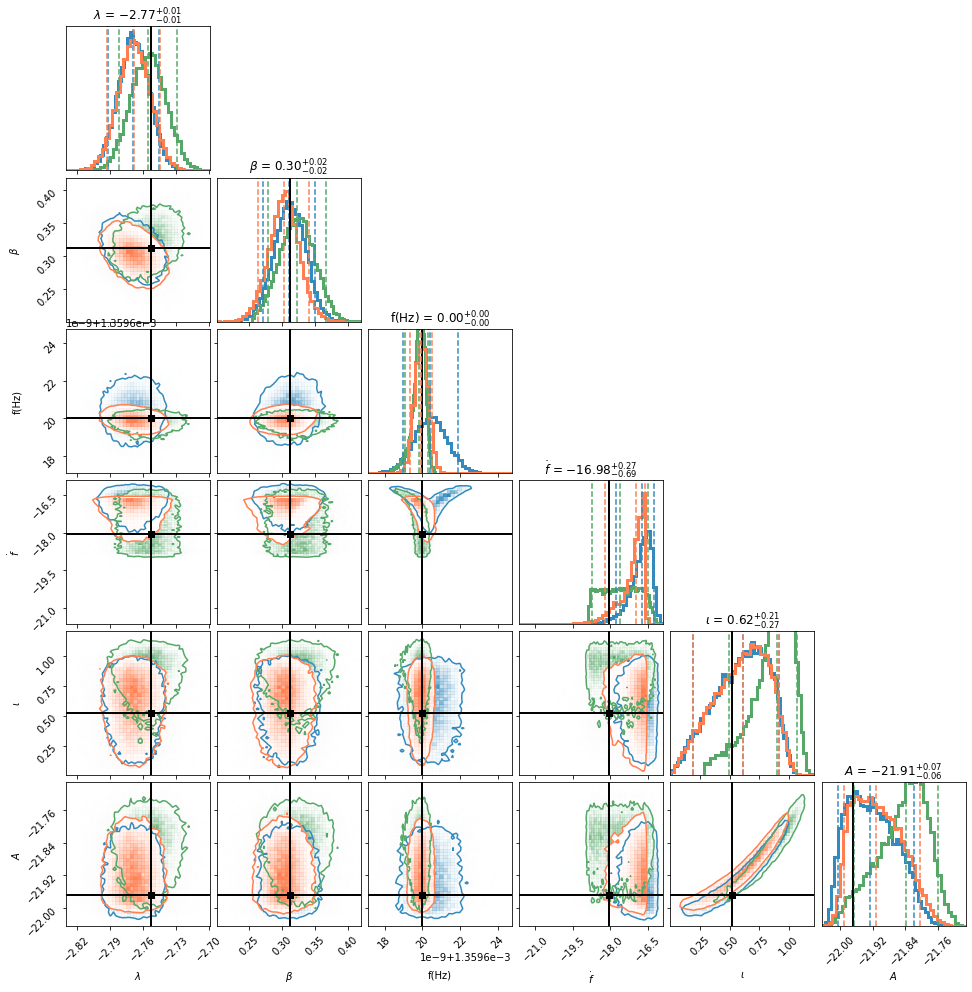

In [41]:
from matplotlib import colors as mcolors
lbls = [r'$\lambda$', r'$\beta$', 'f(Hz)', r'$\dot{f}$', r'$\iota$', r'$A$']

ind_0 = 0
name = 'GW135962'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']-2.0*np.pi
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
print(ind)
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])

bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])
print ('S', datS[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

# corner.corner(datBc,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
#                         color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
#                          levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                           range=rng, levels=[0.9], title_kwargs={"fontsize": 12})



plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

# fig3 = corner.corner(datM,  bins=40,  hist_kwargs={'density':True},  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
#                         color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
#                         range=rng, title_kwargs={"fontsize": 12})


[-16.51027409 -15.9989498  -16.12953877 ... -17.20770629 -16.53809596
 -16.629333  ]
true params [-2.51031000e+00 -5.29009000e-01  1.25313000e-03 -1.80381241e+01
  2.44346000e-01 -2.18652875e+01]
M [-2.47176903 -2.47676281 -2.46621429]
Bh [-2.5183371  -2.47129835 -2.48878343]
Bc [-2.76429118 -2.77401784 -2.73391164]


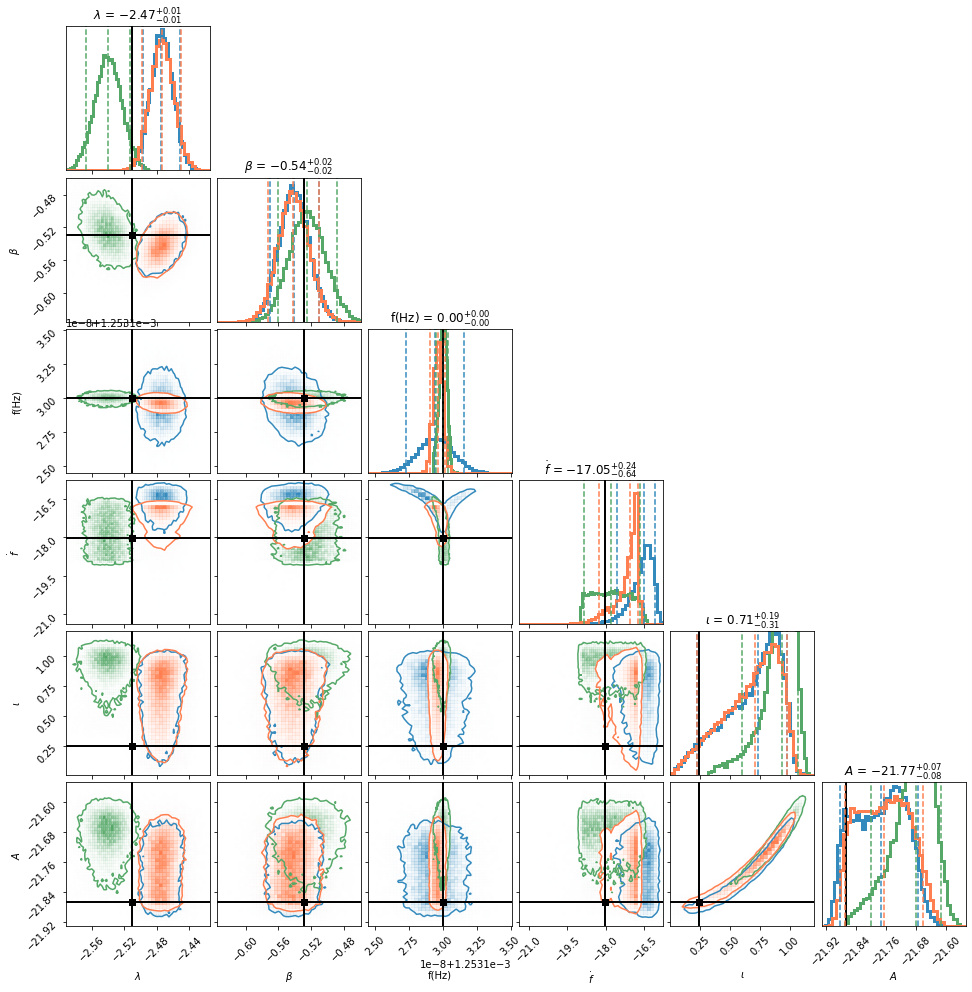

In [42]:
from matplotlib import colors as mcolors
lbls = [r'$\lambda$', r'$\beta$', 'f(Hz)', r'$\dot{f}$', r'$\iota$', r'$A$']

ind_0 = 1
name = 'GW125313'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']-2.0*np.pi
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])

bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                         range=rng,levels=[0.9], title_kwargs={"fontsize": 12})



plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

# fig3 = corner.corner(datM,  bins=40,  hist_kwargs={'density':True},  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
#                         color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
#                         title_kwargs={"fontsize": 12})


[-16.76452952 -16.56739169 -16.50286475 ... -17.35987982 -17.28734966
 -16.85774545]
true params [-2.18009000e+00  8.65683000e-02  1.81324000e-03 -1.76883012e+01
  5.23599000e-01 -2.17538068e+01]
M [-2.18152724 -2.17962334 -2.17609005]
Bh [-2.19151623 -2.18304471 -2.18030053]
Bc [2.28370438 2.30788848 2.25490345]


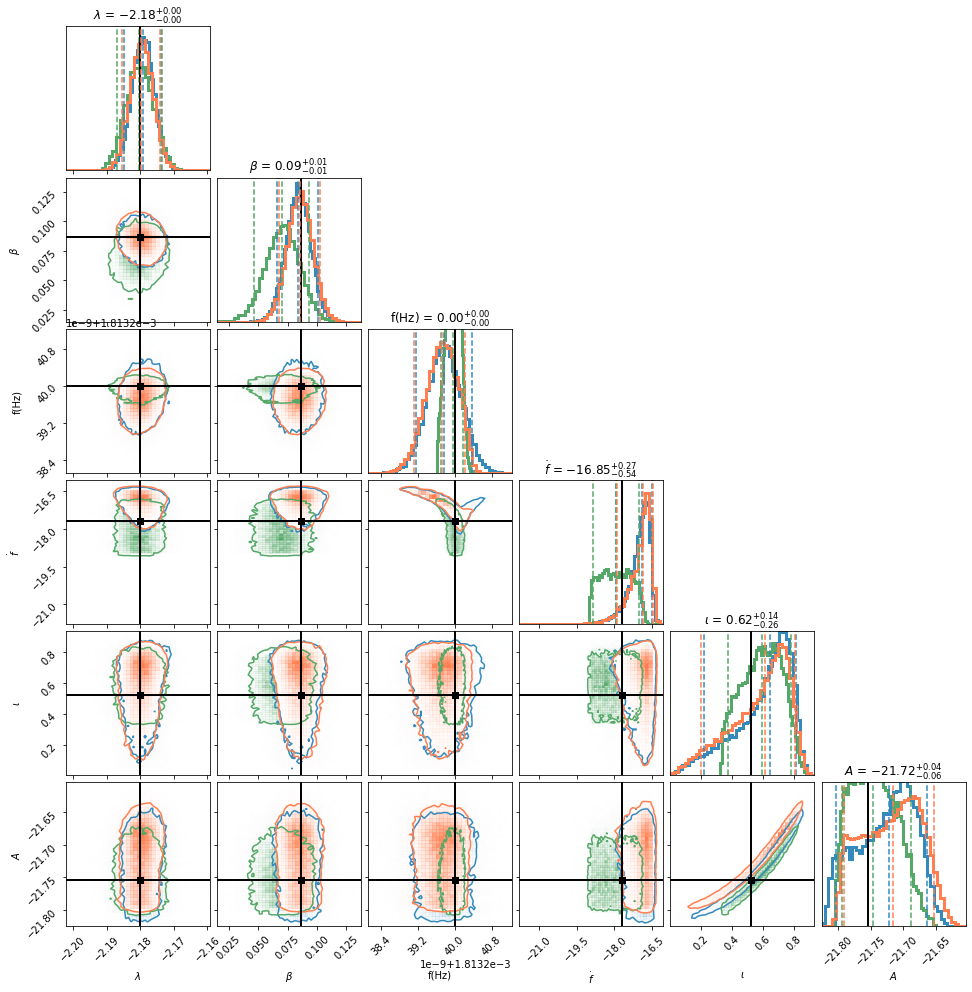

In [43]:
ind_0 = 2
name = 'GW181324'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']-2.0*np.pi
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])

bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                         range=rng, levels=[0.9], title_kwargs={"fontsize": 12})



plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

[-15.80854626 -15.5403608  -15.6068499  ... -15.74819414 -15.75600358
 -15.76585946]
true params [ 2.28603000e+00  4.90263000e-01  1.66667000e-03 -1.76597426e+01
  1.22173000e+00 -2.21339443e+01]
M [2.30740303 2.29664387 2.30714018]
Bh [2.25228373 2.31715919 2.26997009]
Bc [0.41329957 0.41252306 0.41953279]


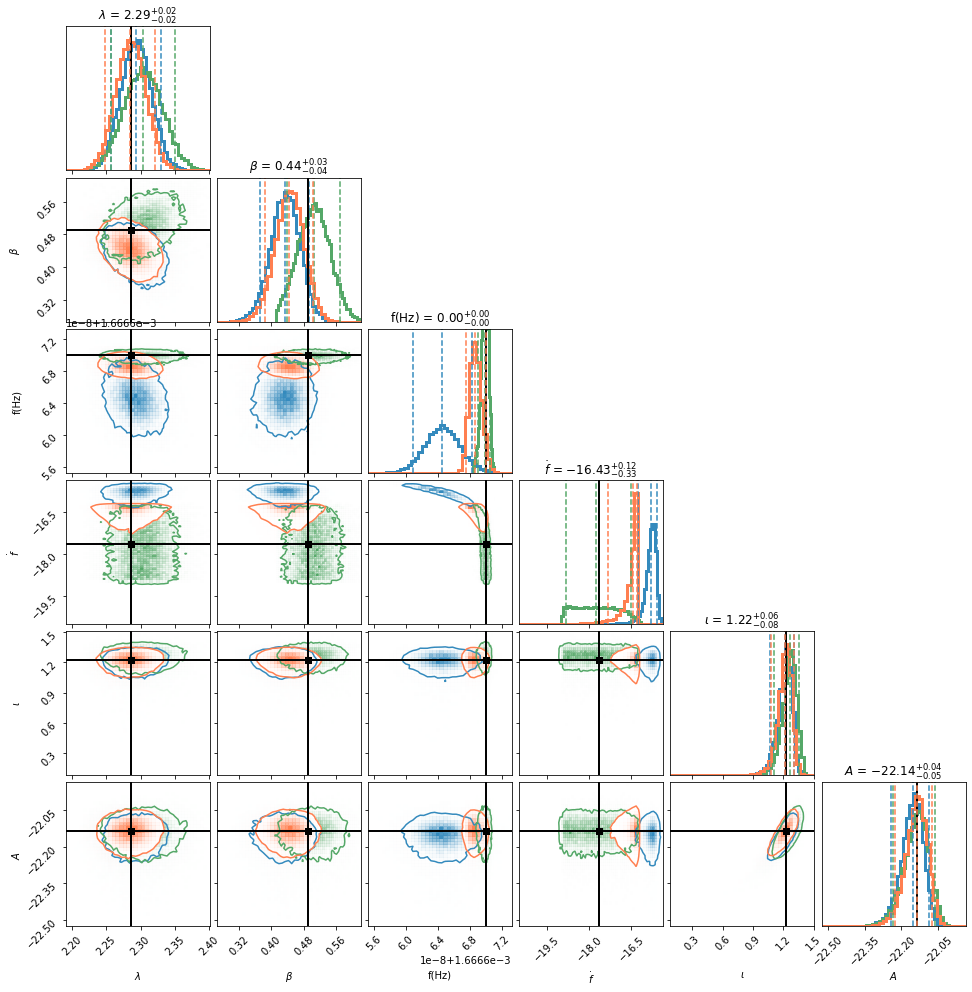

In [44]:
ind_0 = 3
name = 'GW166667'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])

bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                         range=rng, levels=[0.9], title_kwargs={"fontsize": 12})

plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

[-16.36012804 -17.13935133 -16.71371552 ... -17.55755501 -17.37063339
 -17.16600449]
true params [ 2.97387000e+00  6.53451000e-01  1.94414000e-03 -1.71877737e+01
  7.50492000e-01 -2.18212158e+01]
M [2.97596977 2.98145406 2.97732834]
Bh [2.96366844 2.95764856 2.9742328 ]
Bc [-2.50907295 -2.53937532 -2.51800661]


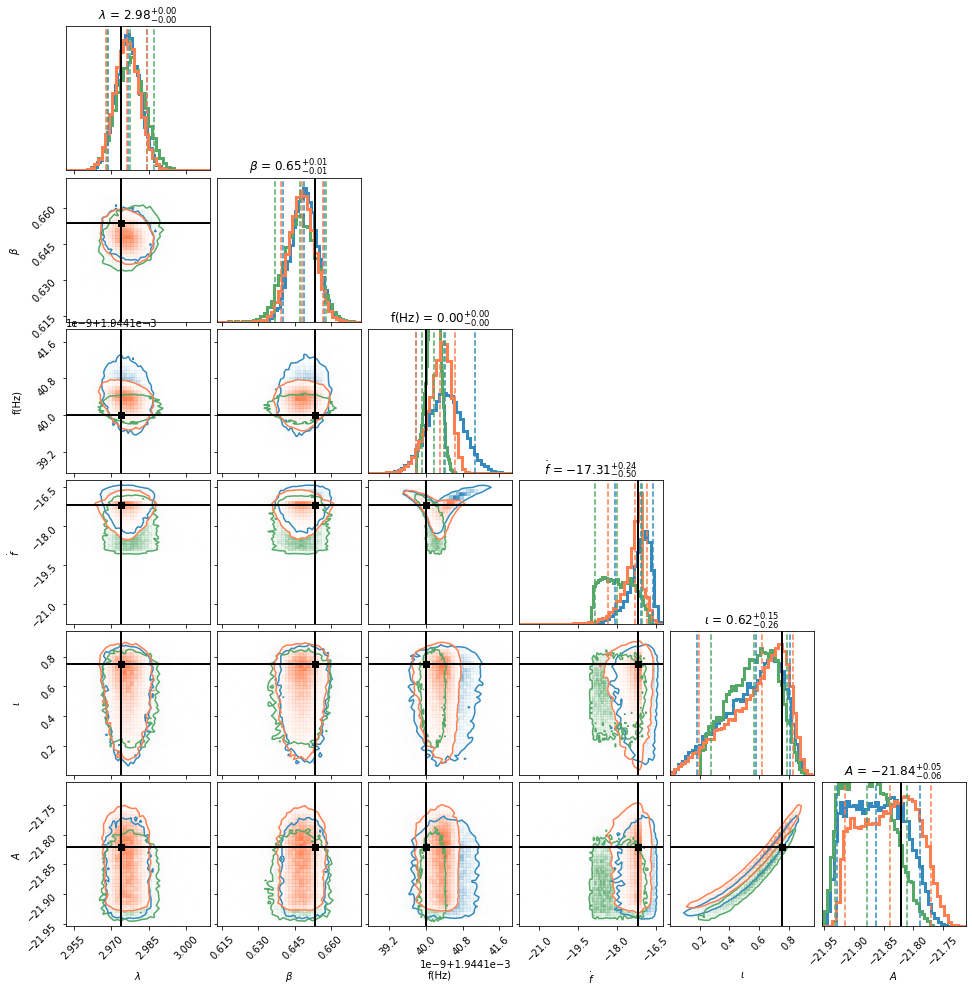

In [45]:
ind_0 = 4
name = 'GW194414'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])

bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])
rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                         range=rng, levels=[0.9], title_kwargs={"fontsize": 12})

plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

[-15.67272871 -16.14599453 -15.87961792 ... -16.08210175 -16.06834265
 -16.05066955]
true params [ 4.29700000e-01 -3.54825000e-01  3.22061000e-03 -1.67579889e+01
  1.61693470e+00 -2.22709114e+01]
M [0.42552212 0.42681983 0.42676967]
Bh [0.4305219  0.42423348 0.41838361]
Bc [2.10358412 2.10404941 2.10281337]


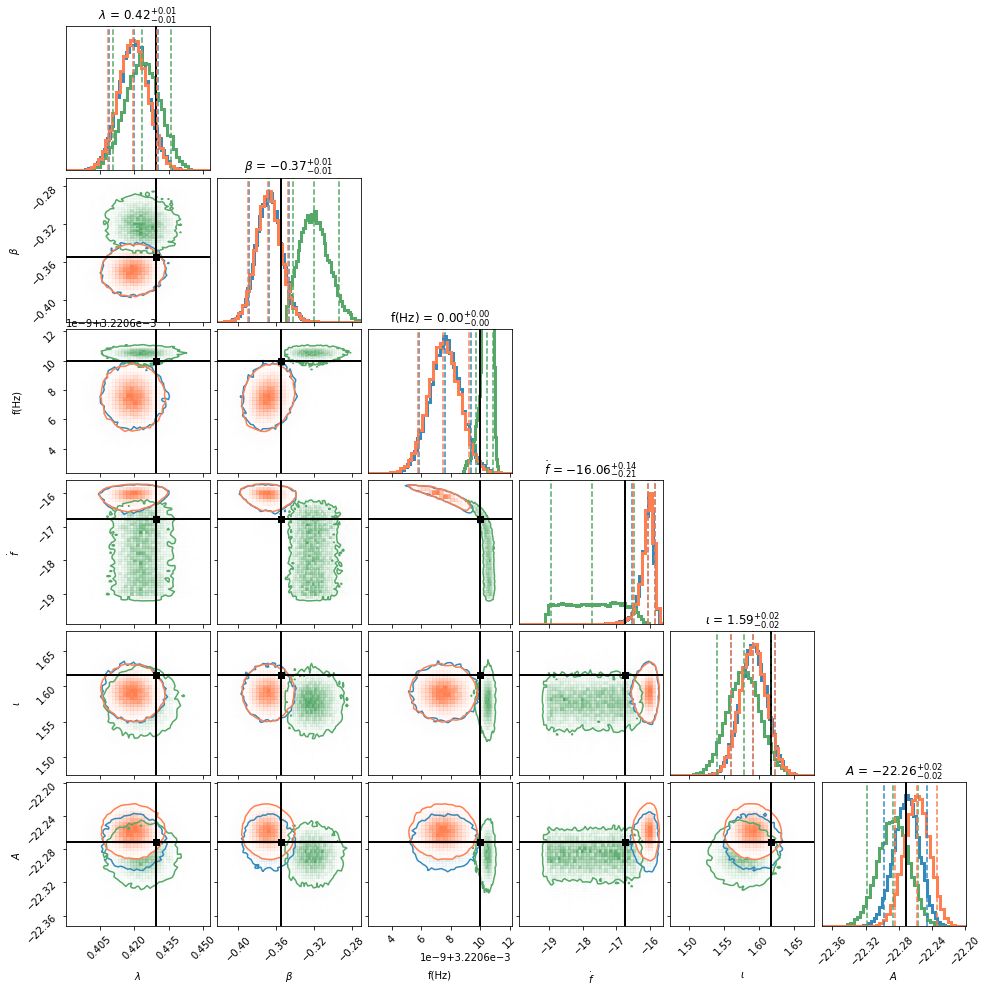

In [46]:
ind_0 = 5
name = 'GW322061'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])


bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                         range=rng, levels=[0.9], title_kwargs={"fontsize": 12})

plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

[-16.28405966 -15.7261214  -15.77766272 ... -17.06480724 -16.71440654
 -16.85691082]
true params [-1.13534000e+00  8.16989000e-01  3.51250000e-03 -1.65550656e+01
  1.50632860e+00 -2.24820523e+01]
M [-1.14272741 -1.13918092 -1.14655687]
Bh [-1.18131019 -1.1355783  -1.11761886]
Bc [1.76571622 1.76653671 1.76324139]


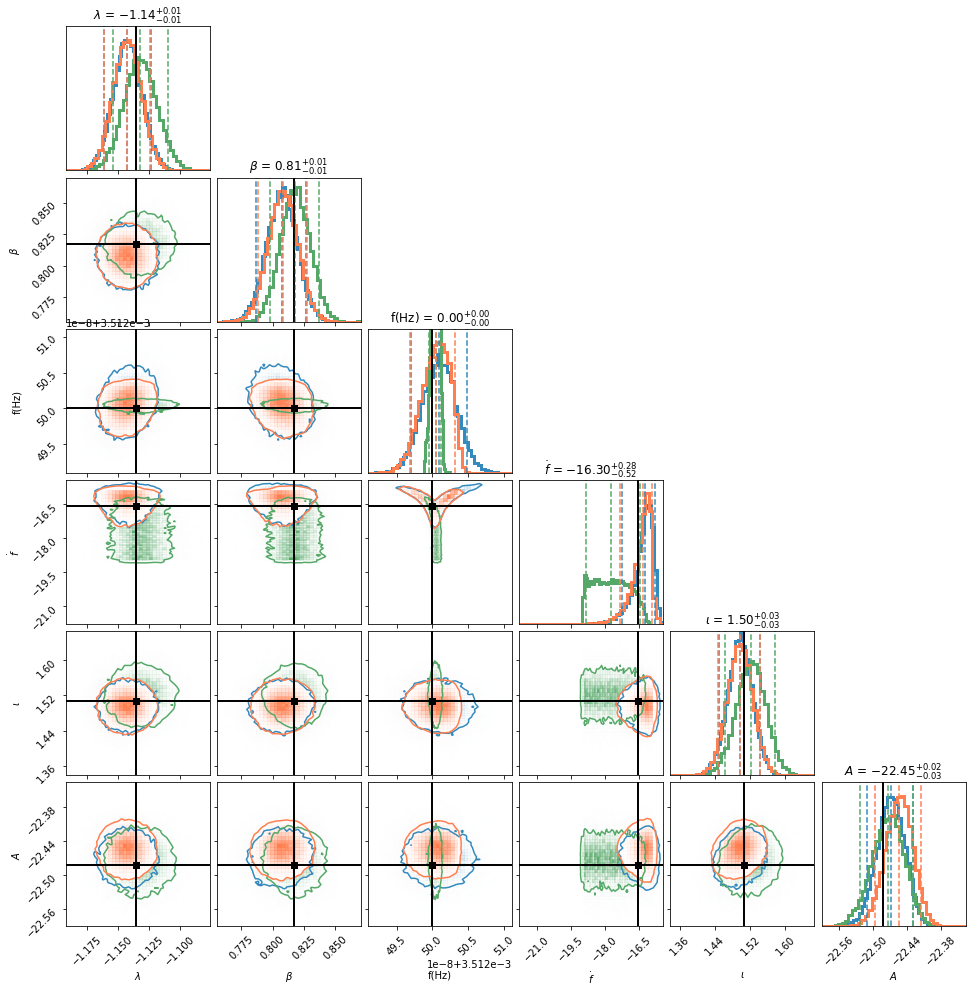

In [47]:
ind_0 = 6
name = 'GW351250'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']-2.0*np.pi
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])


bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                         range=rng, levels=[0.9], title_kwargs={"fontsize": 12})

plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

[-15.11892409 -15.1382137  -15.11116535 ... -15.12444349 -15.12237904
 -15.12511248]
true params [ 2.28603000e+00  4.90263000e-01  1.68350000e-03 -1.76437430e+01
  1.67948105e+00 -2.21310342e+01]
M [2.17774507 2.21008648 2.23699545]
Bh [2.10542507 2.10131727 2.10017722]
Bc [2.975895   2.97819505 2.97731067]


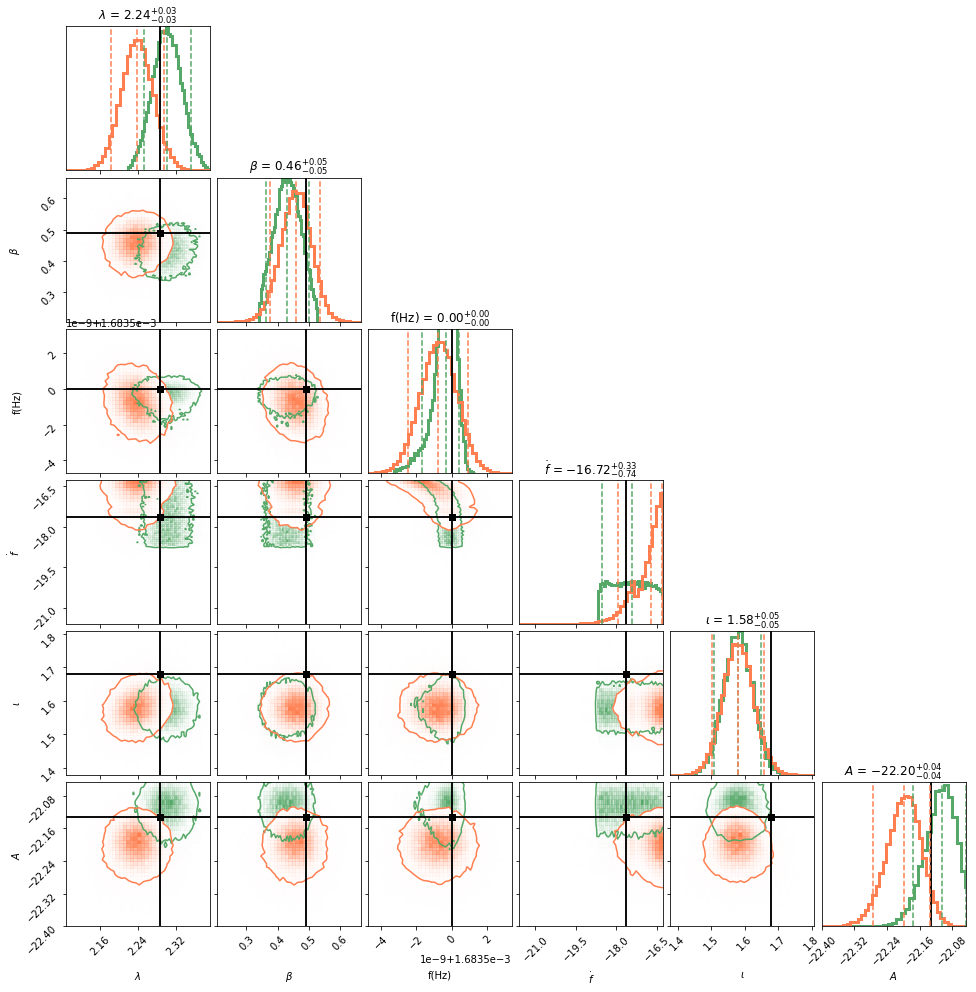

In [48]:
ind_0 = 7
name = 'GW168350'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])


bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datS,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

# corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
#                         color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
#                          levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                          levels=[0.9], title_kwargs={"fontsize": 12})

plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

[-15.88688399 -16.12025746 -15.90875247 ... -15.97050681 -16.05620773
 -16.04310761]
true params [ 2.10225000e+00 -8.22050000e-02  6.22028000e-03 -1.51257916e+01
  6.45772000e-01 -2.21952998e+01]
M [2.09971571 2.09988213 2.10053708]
Bh [2.28638826 2.13148861 2.17916866]
Bc [-1.12419027 -1.11599297 -1.12729182]


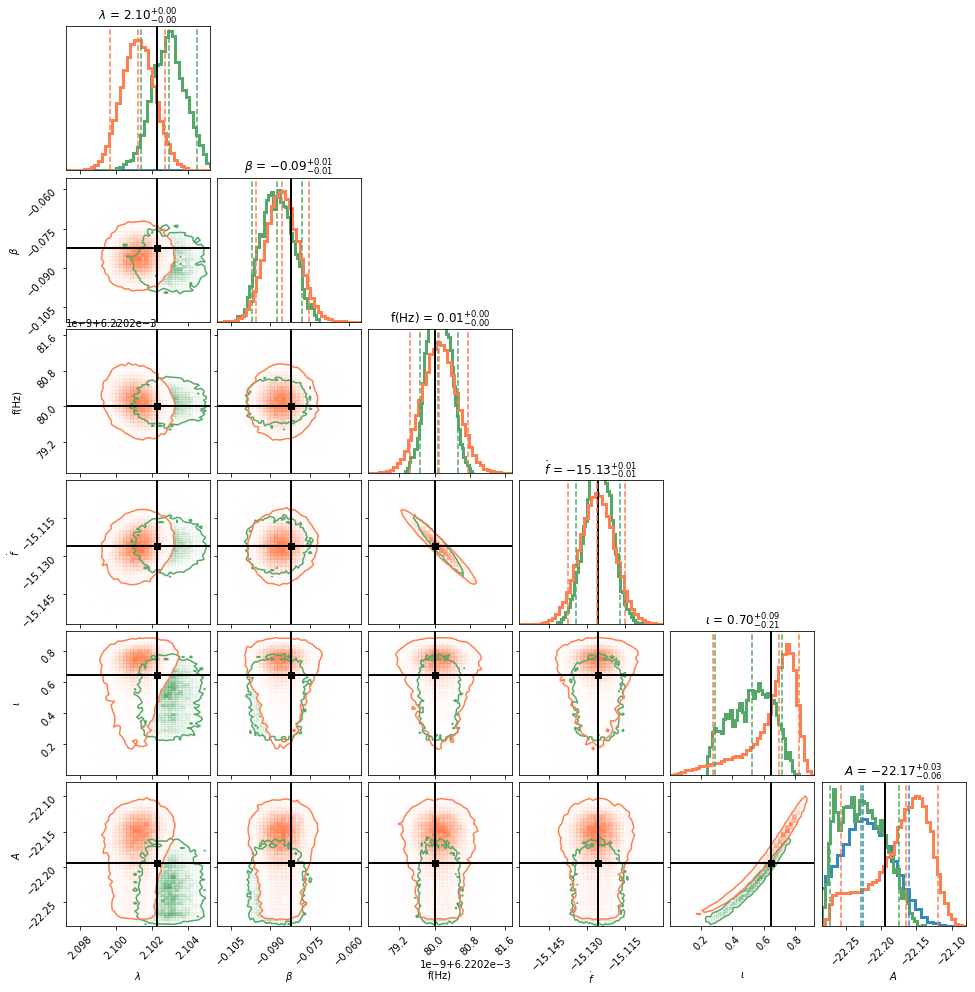

In [49]:
ind_0 = 8
name = 'GW622028'
inds_d = VGBs[name]

ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])


bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                          levels=[0.9], title_kwargs={"fontsize": 12})

plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

[-17.02147473 -16.54876158 -16.78020566 ... -17.30192    -17.43045049
 -17.03626837]
true params [ 1.76872000e+00  1.01404000e-01  2.61301000e-03 -1.65367599e+01
  1.51669000e+00 -2.17772913e+01]
M [1.7652657  1.76464911 1.76018899]
Bh [1.76295455 1.75650379 1.76261726]
Bc [-2.18027765 -2.18014139 -2.17735144]


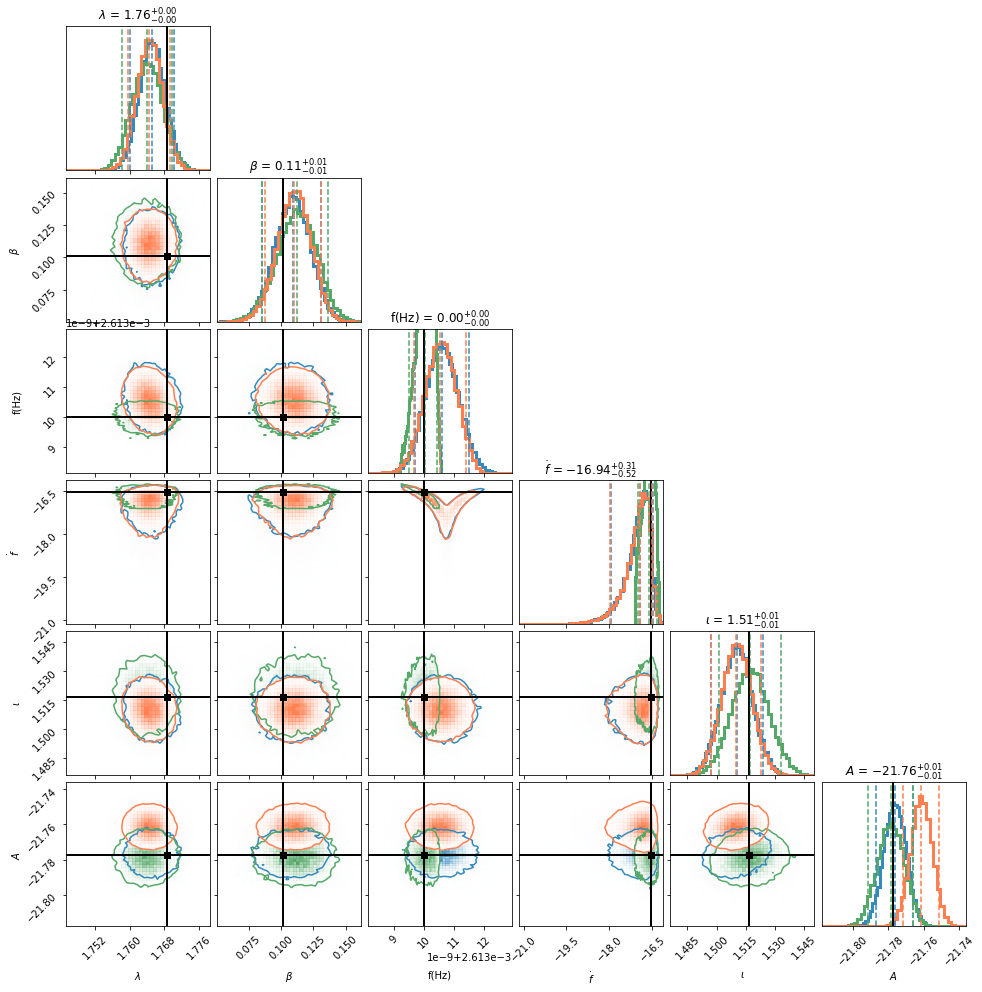

In [50]:
ind_0 = 9
name = 'GW261301'
inds_d = VGBs[name]
s = 1
ind = VGBs[name]['BH']
datBh = np.zeros((len(Bham_data[ind]), len(lbls)))
datBh[:, 0] = Bham_data[ind]['EclipticLongitude'] -np.pi
datBh[:, 1] = Bham_data[ind]['EclipticLatitude']
datBh[:, 2] = Bham_data[ind]['Frequency']
datBh[:, 3] = np.log10(np.abs(Bham_data[ind]['FrequencyDerivative']))
datBh[:, 4] = Bham_data[ind]['Inclination']
datBh[:, 5] = np.log10(Bham_data[ind]['Amplitude'])

print (datBh[:, 3])

ind = VGBs[name]['MM']
datM = np.zeros((len(MM_data[ind]), len(lbls)))
datM[:, 0] = MM_data[ind]['EclipticLongitude']
datM[:, 1] = MM_data[ind]['EclipticLatitude']
datM[:, 2] = MM_data[ind]['Frequency']
datM[:, 3] = np.log10(np.abs(MM_data[ind]['FrequencyDerivative']))
datM[:, 4] = MM_data[ind]['Inclination']
datM[:, 5] = np.log10(MM_data[ind]['Amplitude'])

ind = VGBs[name]['BC']
datBc = np.zeros((len(Barc_data[ind]), len(lbls)))
datBc[:, 0] = Barc_data[ind]['EclipticLongitude']
datBc[:, 1] = Barc_data[ind]['EclipticLatitude']
datBc[:, 2] = Barc_data[ind]['Frequency']
datBc[:, 3] = np.log10(np.abs(Barc_data[ind]['FrequencyDerivative']))
datBc[:, 4] = np.arccos(np.cos(Barc_data[ind]['Inclination']))
datBc[:, 5] = np.log10(Barc_data[ind]['Amplitude'])

ind = VGBs[name]['S']
datS = np.zeros((len(S_data[ind]), len(lbls)))
datS[:, 0] = S_data[ind]['EclipticLongitude']
datS[:, 1] = S_data[ind]['EclipticLatitude']
datS[:, 2] = S_data[ind]['Frequency']
datS[:, 3] = np.log10(np.abs(S_data[ind]['FrequencyDerivative']))
datS[:, 4] = np.arccos(np.cos(S_data[ind]['Inclination']))
datS[:, 5] = np.log10(S_data[ind]['Amplitude'])


bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ind_0)

tr_s = np.array([lam, bet, f0, np.log10(fdot), iota, np.log10(Amp)])
print ("true params", tr_s)
print ('M', datM[:3, 0])
print ('Bh', datBh[:3,0])
print ('Bc', datBc[:3,0])

rng = [0.999, 0.999, 0.999, (-20.5,-15.5), 0.99, 0.99]
rng = []
# print (datBh.min(), datBc.min(), datM.min())
# print (max(datBh.max(), datBc.max(), datM.max()))
for i in range(len(lbls)):
    oner = ( min(datBh[:,i].min(), datS[:, i].min(), datM[:,i].min()), max(datBh[:, i].max(), datS[:,i].max(), datM[:,i].max()) )
    rng.append(oner)

fig2 =  corner.corner(datBh,  bins=40, hist_kwargs={'density':True, 'lw':3}, plot_datapoints=False, fill_contours=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='#348ABD', truths= tr_s, truth_color='k', use_math_test=True,\
                        levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datS,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color=plotpal[3], truths= tr_s, truth_color='k', use_math_test=True,\
                         levels=[0.9], title_kwargs={"fontsize": 12})

corner.corner(datM,  bins=40,  hist_kwargs={'density':True, 'lw':3}, fig=fig2, plot_datapoints=False, fill_contours=False,  labels=lbls, quantiles=[0.05, 0.5, 0.95], show_titles=True, \
                        color='coral', truths= tr_s, truth_color='k', use_math_test=True,\
                         range=rng, levels=[0.9], title_kwargs={"fontsize": 12})

plt.show()
fig2.savefig("/home/stefan/Repositories/ldc1_evaluation/Stefan/VGB_"+str(ind_0)+".png")

#### Compute Jensen-Shannon divergence for the frequency

In [51]:
for name in VGBs.keys():
    ind_d = VGBs[name]
    fr_Bh = Bham_data[ind_d['BH']]['Frequency']
    fr_MM = MM_data[ind_d['MM']]['Frequency']
    fr_Bc = (Barc_data[ind_d['BC']]['Frequency'])[::8]
    
    #computing pair-wise JSd 
    samplesBh_MM = [fr_Bh, fr_MM]
    JS_BhMM = jensen_shannon_divergence(samplesBh_MM)
    samplesBh_Bc =  [fr_Bh, fr_Bc]
    JS_BhBc = jensen_shannon_divergence(samplesBh_Bc)
    samplesMM_Bc =  [fr_MM, fr_Bc]
    JS_MMBc = jensen_shannon_divergence(samplesMM_Bc)
    
    print (name)
    print ('Bh-MM', JS_BhMM, 'Bh-Bc', JS_BhBc, 'MM-Bc', JS_MMBc)
    print (JS_BhMM, JS_BhBc,  JS_MMBc)
    

    
    
    

GW135962
Bh-MM 0.18149 Bh-Bc 0.69315 MM-Bc 0.69315
0.18149 0.69315 0.69315
GW125313
Bh-MM 0.24991 Bh-Bc 0.69315 MM-Bc 0.69315
0.24991 0.69315 0.69315
GW181324
Bh-MM 0.01197 Bh-Bc 0.69315 MM-Bc 0.69315
0.01197 0.69315 0.69315
GW166667
Bh-MM 0.5053 Bh-Bc 0.69315 MM-Bc 0.69315
0.5053 0.69315 0.69315
GW194414
Bh-MM 0.07511 Bh-Bc 0.69315 MM-Bc 0.69315
0.07511 0.69315 0.69315
GW322061
Bh-MM 0.00145 Bh-Bc 0.69315 MM-Bc 0.69315
0.00145 0.69315 0.69315
GW351250
Bh-MM 0.02948 Bh-Bc 0.69315 MM-Bc 0.69315
0.02948 0.69315 0.69315
GW168350
Bh-MM 0.69315 Bh-Bc 0.69315 MM-Bc 0.69315
0.69315 0.69315 0.69315
GW622028
Bh-MM 0.69315 Bh-Bc 0.69315 MM-Bc 0.69315
0.69315 0.69315 0.69315
GW261301
Bh-MM 0.00393 Bh-Bc 0.69315 MM-Bc 0.69315
0.00393 0.69315 0.69315


## Computing the likelihood with the submitted points

### Likelihood evaluation 



In [52]:
fastGB = FastGB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic")


def ComputeLogLikelihood(Subm):
    
    df = 1.0/Tobs
    bet = Subm['EclipticLatitude']
    lam = Subm['EclipticLongitude']
    Amp = Subm['Amplitude'] 
    f0 = Subm['Frequency']
    fdot = Subm['FrequencyDerivative']
    iota = Subm['Inclination']
    psi = Subm['Polarization']
    phi0 = Subm['InitialPhase']
    
    prm = np.array([f0, fdot, bet, lam, Amp, iota, psi, phi0]) 
    Xf, Yf, Zf = fastGB.onefourier(simulator='synthlisa', params=prm, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
    
        
#     Af = FrequencyArray.FrequencyArray( ((Zf[:] - Xf[:])/np.sqrt(2.0))/df, dtype=np.complex128, kmin=Xf.kmin, df=Xf.df)
#     Ef = FrequencyArray.FrequencyArray( ((Zf[:] - 2.0*Yf[:] + Xf[:])/np.sqrt(6.0))/df, dtype=np.complex128, kmin=Xf.kmin, df=Xf.df) 
    
    Af = (np.array(Zf[:] - Xf[:])/np.sqrt(2.0))/df
    Ef = ((Zf[:] - 2.0*Yf[:] + Xf[:])/np.sqrt(6.0))/df
    
     
    ib = Xf.kmin
    ie = Xf.kmin+len(Xf) 
    fr = np.arange(Xf.kmin, Xf.kmin+len(Xf))*df
    
    SA = tdi.noisepsd_AE(fr, model='Proposal', includewd=None)
    SNR2 = np.sum( np.real(Adf[ib:ie] * np.conjugate(Af.data) + Edf[ib:ie] * np.conjugate(Ef.data))/SA )
    hh = np.sum((np.absolute(Af.data)**2 + np.absolute(Ef.data)**2) /SA)
    
    loglik = 4.0*df*( SNR2 - 0.5 * hh )
    return (loglik)  
    
    
    
    
    
    

In [53]:
i_upto = 10

for ii, name in enumerate(VGBs.keys()):
    ind_d = VGBs[name]
#     print(np.shape(Bham_data[ind_d['BH']]), np.shape(MM_data[ind_d['MM']]['Frequency'][::4]), np.shape(Barc_data[ind_d['BC']][::40]) )
    BHsampl = Bham_data[ind_d['BH']]
    MMsampl = MM_data[ind_d['MM']][::4]
    BCsampl = Barc_data[ind_d['BC']][::40]
    
    bet, lam, Amp, f0, fdot, iota, psi, phi0 = GetParams(p, ii)
    trs= {'EclipticLatitude': bet, 'EclipticLongitude': lam, 'Amplitude': Amp, 'Frequency': f0, \
          'FrequencyDerivative': fdot, 'Inclination': iota, 'Polarization': psi, 'InitialPhase': phi0}
    
    ### adjusting conventions:
    BHsampl['EclipticLongitude']  = BHsampl['EclipticLongitude'] -np.pi
    
    print (name, 'True', ComputeLogLikelihood(trs))
    for j in range(i_upto):
        s_BH = BHsampl[j]
        s_MM = MMsampl[j]
        s_BC = BCsampl[j]
#         print (s_BH['Frequency'], s_MM['Frequency'], s_BC['Frequency'])
        logBH = ComputeLogLikelihood(s_BH)
        logMM = ComputeLogLikelihood(s_MM)
        logBC = ComputeLogLikelihood(s_BC)
        
        print ('likelihoods, BH, MM, BC', logBH, logMM, logBC)
            
        





GW135962 True 551.9165266328635
likelihoods, BH, MM, BC 527.6301603666648 541.8397385229937 106.12016307675637
likelihoods, BH, MM, BC 568.6848854860685 556.0860551169089 103.95918704838279
likelihoods, BH, MM, BC 529.7560632597701 549.4105216728274 95.38084474807323
likelihoods, BH, MM, BC 550.7111691204562 548.1635066917961 100.37504146065906
likelihoods, BH, MM, BC 544.8564024222796 542.4602122829834 106.58230470214313
likelihoods, BH, MM, BC 549.5354216937584 545.9059923906293 108.09319014778109
likelihoods, BH, MM, BC 519.384892499239 545.4825549324021 109.70256882335207
likelihoods, BH, MM, BC 537.1918495759951 540.2895612213397 105.89462283324234
likelihoods, BH, MM, BC 541.5702406235025 535.9225091206783 105.70266075811539
likelihoods, BH, MM, BC 528.9364413882 547.2407652128229 101.72295220253176
GW125313 True 82.16660203241118
likelihoods, BH, MM, BC 124.16514097801907 162.19912321708082 571.6855908464806
likelihoods, BH, MM, BC 186.58163174290553 189.00071997536725 571.87317